In [2]:
from datetime import datetime, timedelta

# pandas and plotting libraries for visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# module containing functions for manipulation pyspark dataframes
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

# class which will let us create spark objects
from pyspark.sql import SparkSession

# modeling
from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# helper functions for the class
from helpers import display, read_df, write_df, feature_importances

## [PySpark ML docs](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html)

## Create a Spark Session

In [3]:
spark = (
    SparkSession
    .builder
    .appName('model')
    .master('local[2]')
    .getOrCreate()
)

## Feature generation function

In [4]:
def build_features(raw_df):
    avg_miles_by_census_tract = (
        raw_df
        .groupby('dropoff_census_tract')
        .agg(f.avg(f.col('trip_miles')).alias('avg_trip_miles_by_dropoff_census_tract'))
    )

    features = (
        raw_df
        .where(f.col('tips').isNotNull())
        .join(avg_miles_by_census_tract, on='dropoff_census_tract')
        .select(
            'trip_id',
            'company',
            'trip_miles',
            'fare',
            f.month('start_time').alias('start_month'),
            f.dayofweek('start_time').alias('start_day_of_week'),
            f.hour('start_time').alias('start_hour'),
            (
                f.unix_timestamp(f.col('end_time'))
                - f.unix_timestamp(f.col('start_time'))
            ).alias('trip_minutes'),
            'avg_trip_miles_by_dropoff_census_tract',
            f.col('tips').alias('label'),
        )
    )
    
    return features

## Build Pipeline

In [5]:
df = read_df(spark, '../taxi_2016')

In [6]:
# only have tip data for credit card transactions
tips = df.where(f.col('payment_type') == 'Credit Card')

In [7]:
tips.count()

1317855

In [8]:
train_raw, test_raw = tips.randomSplit([0.7, 0.3])

In [9]:
train = build_features(train_raw)

In [10]:
test = build_features(test_raw)

In [11]:
# check for nulls
total_rows = train.count()
display(
    t.agg(
        *[(total_rows - f.count(c)).alias(c) for c in df.columns]
    )
)

,trip_id,taxi_id,start_time,end_time,trip_miles,pickup_census_tract,dropoff_census_tract,fare,tips,trip_total,payment_type,company
0,-2705955,-2705955,-2705955,-2705571,-2705946,-1829692,-1821781,-2705955,-2705955,-2705955,-2705955,-1614388


In [12]:
categorical_cols = ['start_month', 'start_day_of_week', 'start_hour', 'company']
indexed_categorical_cols = [c + '_ind' for c in categorical_cols]

numeric_cols = ['trip_miles', 'fare', 'trip_minutes', 'avg_trip_miles_by_dropoff_census_tract']
imputed_numeric_cols = [c + '_imp' for c in numeric_cols]

In [13]:
train = train.select('trip_id', *categorical_cols, *[f.col(c).cast(t.DoubleType()) for c in numeric_cols], 'label')
train = train.fillna('no_company')

In [14]:
test = test.select('trip_id', *categorical_cols, *[f.col(c).cast(t.DoubleType()) for c in numeric_cols], 'label')
test = test.fillna('no_company')

In [15]:
pipeline = Pipeline().setStages(
    [
        *[StringIndexer(inputCol=c, outputCol=c+'_ind', handleInvalid='keep') for c in categorical_cols],
        Imputer(inputCols=numeric_cols, outputCols=imputed_numeric_cols),
        VectorAssembler(inputCols=imputed_numeric_cols + indexed_categorical_cols, outputCol='features'),
        RandomForestRegressor(maxBins=60),
    ]
)

In [19]:
train.count()

678434

In [18]:
%%time

model = pipeline.fit(train)

CPU times: user 53.7 ms, sys: 4.11 ms, total: 57.8 ms
Wall time: 1min


In [29]:
train.cache()
train.count()

678593

In [33]:
%%time

model = pipeline.fit(train)

CPU times: user 30.4 ms, sys: 11.6 ms, total: 42 ms
Wall time: 26.1 s


In [31]:
predictions = model.transform(test)

## Evaluate

In [23]:
evaluator = RegressionEvaluator(
    labelCol='label',
    predictionCol='prediction',
    metricName='rmse'
)
rmse = evaluator.evaluate(predictions)

In [24]:
print('RMSE on test data = {}'.format(rmse))

RMSE on test data = 1.5608943090305698


In [25]:
print('Most important features:')
feature_importances(predictions, model.stages[6], 20)

Most important features:
start_day_of_week_ind: 0.488
start_hour_ind: 0.235
start_month_ind: 0.230
company_ind: 0.044
trip_minutes_imp: 0.002
avg_trip_miles_by_dropoff_census_tract_imp: 0.001
fare_imp: 0.000
trip_miles_imp: 0.000


In [26]:
to_plot = (
    predictions
    .select('prediction', 'label')
    .sample(withReplacement=False, fraction=.01)
    .toPandas()
)

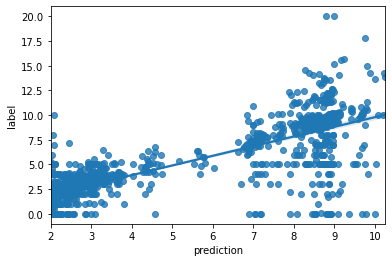

In [27]:
plt.figure()
sns.regplot(to_plot['prediction'], to_plot['label'])

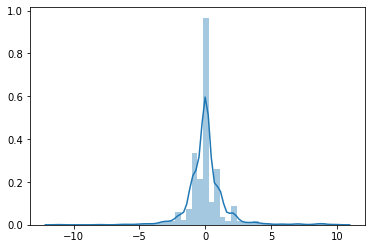

In [28]:
plt.figure()
sns.distplot(to_plot['prediction'] - to_plot['label'])

In [ ]:
spark.stop()